# Elastic support with applied loads

In [11]:
from skfem import *
from skfem.visuals.matplotlib import *
%matplotlib inline
plt.set_cmap('plasma')

<Figure size 432x288 with 0 Axes>

In [12]:
def problem(m, eps2=1e-3, refmode=0):

    e = ElementTriArgyris()
    e.derivatives = 4
    t = 1.
    E = 1.
    nu = 0.0
    D = E * t ** 3 / (12. * (1. - nu ** 2))

    def C(T):
        trT = T[0, 0] + T[1, 1]
        return E / (1. + nu) * \
            np.array([[T[0, 0] + nu / (1. - nu) * trT, T[0, 1]],
                      [T[1, 0], T[1, 1] + nu / (1. - nu) * trT]])

    def K(ddu):
        return -ddu

    def M(ddu):
        return t ** 3 / 12. * C(-ddu)

    def divM(T): # input K
        trT1 = T[0, 0, 0] + T[1, 1, 0]
        trT2 = T[0, 0, 1] + T[1, 1, 1]
        return t ** 3 / 12 * E / (1. + nu) * \
            np.array([T[0, 0, 0] + nu / (1. - nu) * trT1 + T[0, 1, 1],
                      T[1, 0, 0] + T[1, 1, 1] + nu / (1. - nu) * trT2])

    def gradM(T): # input K
        trT1 = T[0, 0, 0] + T[1, 1, 0]
        trT2 = T[0, 0, 1] + T[1, 1, 1]
        return t ** 3 / 12 * E / (1. + nu) * \
            np.array([[[T[0, 0, 0] + nu / (1. - nu) * trT1, T[0, 0, 1] + nu / (1. - nu) * trT2],
                       [T[0, 1, 0], T[0, 1, 1]]],
                      [[T[1, 0, 0], T[1, 0, 1]],
                       [T[1, 1, 0] + nu / (1. - nu) * trT1, T[1, 1, 1] + nu / (1. - nu) * trT2]]])

    def Vn(dddu, n):
        from skfem.helpers import dot, ddot, dddot, prod
        s = n.copy()
        s[0] = -n[1]
        s[1] = n[0]
        return dot(divM(-dddu), n) + dddot(gradM(-dddu), prod(n, s, s))

    def Mnn(ddu, n):
        from skfem.helpers import ddot, prod
        return ddot(M(ddu), prod(n, n))

    def Mns(ddu, n):
        from skfem.helpers import ddot, prod
        s = n.copy()
        s[0] = -n[1]
        s[1] = n[0]
        return ddot(M(ddu), prod(n, s))

    @BilinearForm
    def bilinf(u, v, w):
        from skfem.helpers import ddot, dd
        return ddot(M(dd(u)), K(dd(v)))

    eps1 = 1
    eps2 = eps2

    def F(x, y):
        return 0 + 0. * x

    @LinearForm
    def linf(v, w):
        return F(*w.x) * v

    gamma1 = 1e-3
    gamma2 = gamma1
    gamma3 = gamma1
    
    @BilinearForm
    def penalty_1f(u, v, w):
        from skfem.helpers import d, ddd, dot
        return 1. / (eps1 + gamma1 * w.h ** 3) * u * v\
                   + gamma1 * w.h ** 3 / (eps1 + gamma1 * w.h ** 3) * (Vn(ddd(u), w.n) * v + u * Vn(ddd(v), w.n))\
                   + gamma1 * eps1 * w.h ** 3 / (eps1 + gamma1 * w.h ** 3) * Vn(ddd(u), w.n) * Vn(ddd(v), w.n)

    @BilinearForm
    def penalty_2f(u, v, w):
        from skfem.helpers import d, dd, dot
        return 1. / (eps2 + gamma2 * w.h) * dot(d(u), w.n) * dot(d(v), w.n)\
                   - gamma2 * w.h / (eps2 + gamma2 * w.h) * (dot(d(u), w.n) * Mnn(dd(v), w.n) + Mnn(dd(u), w.n) * dot(d(v), w.n))\
                   + gamma2 * eps2 * w.h / (eps2 + gamma2 * w.h) * Mnn(dd(u), w.n) * Mnn(dd(v), w.n)

    @BilinearForm
    def penalty_3h(u, v, w):
        from skfem.helpers import d, dd, dot
        return (1. / (gamma3 * w.h ** 2) * u * v + Mns(dd(u), w.n) * v + Mns(dd(v), w.n) * u) / w.h \
            * (np.abs(w.x[0] - 0.5) == 0.5) * (np.abs(w.x[1] - 0.5) == 0.5)

    @BilinearForm
    def penalty_3v(u, v, w):
        from skfem.helpers import d, dd, dot
        return ( Mns(dd(u), w.n) * v + Mns(dd(v), w.n) * u) / w.h \
            * (np.abs(w.x[0] - 0.5) == 0.5) * (np.abs(w.x[1] - 0.5) == 0.5)
    
    @BilinearForm
    def trad_pena(u, v, w):
        from skfem.helpers import d, dd, dot
        return 1. / eps2 * dot(d(u), w.n) * dot(d(v), w.n) + 1. / eps1 * u * v
    
    def gM(x, y):
        return 10 * (y<0.25) + 0. * x
    
    def gV(x, y):
        return (y<0.75) + 0. * x
    
    @LinearForm
    def rhs(v, w):
        from skfem.helpers import d, dd, ddd, dot
        return  eps2 / (eps2 + gamma2 * w.h) * gM(*w.x) * (-dot(d(v), w.n) + gamma2 * w.h * Mnn(dd(v), w.n))\
            + eps1 / (eps1 + gamma1 * w.h ** 3) * gV(*w.x) * (v + gamma1 * w.h ** 3 * Vn(ddd(v), w.n))
    
    @LinearForm
    def trad_rhs(v, w):
        from skfem.helpers import d, dd, ddd, dot
        return - gM(*w.x) * dot(d(v), w.n) + gV(*w.x) * v

    basis = InteriorBasis(m, e)
    fbasis = FacetBasis(m, e)
    fbasis_pena = FacetBasis(m, e,
                             facets=m.facets_satisfying(lambda x: np.abs(x[0] - 0.5) == 0.5))
    cbasis_h = FacetBasis(m, e,
                          facets=m.facets_satisfying(lambda x: np.abs(x[1] - 0.5) == 0.5),
                          quadrature=(np.array([[0.0, 1.0]]),
                                      np.array([1.0, 1.0])))
    cbasis_v = FacetBasis(m, e,
                          facets=m.facets_satisfying(lambda x: np.abs(x[0] - 0.5) == 0.5),
                          quadrature=(np.array([[0.0, 1.0]]),
                                      np.array([1.0, 1.0])))

    A = asm(bilinf, basis)
    B11 = asm(penalty_1f, fbasis)
    B22 = asm(penalty_2f, fbasis)
    B3 = asm(penalty_3h, cbasis_h)
    B4 = asm(penalty_3v, cbasis_v)
    C1 = asm(trad_pena, fbasis)
    b = asm(linf, basis)
    b_nit = asm(rhs, fbasis)
    b_trad = asm(trad_rhs, fbasis)

    x = solve(A + B11 + B22, b + b_nit)
    y = solve(A + C1, b + b_trad)
    Nrefs = 4
    
    def project(fun,
                basis_from = None,
                basis_to = None,
                diff = None,
                I = None):
        @BilinearForm
        def mass(u, v, w):
            p = u * v
            return sum(p) if isinstance(basis_to.elem, ElementVectorH1) else p

        @LinearForm
        def funv(v, w):
            p = fun(*w.x) * v
            return sum(p) if isinstance(basis_to.elem, ElementVectorH1) else p

        @BilinearForm
        def deriv(u, v, w):
            from skfem.helpers import grad
            du = grad(u)
            return du[diff] * v

        M = asm(mass, basis_to)

        if not isinstance(fun, ndarray):
            f = asm(funv, basis_to)
        else:
            if diff is not None:
                f = asm(deriv, basis_from, basis_to) @ fun
            else:
                f = asm(mass, basis_from, basis_to) @ fun

        if I is not None:
            return solve(*condense(M, f, I=I, expand=False))

        return solve(M, f)
    
    X = project(x, basis, basis, diff=0)
    
    plot(basis, X, Nrefs=Nrefs, colorbar=True)
    draw(m, figsize=(6, 6))
    
    # interior error

    @Functional
    def est_interior(w):
        from skfem.helpers import dddd
        u = w['w']
        D4u = dddd(u)
        return w.h ** 4 * (D * (D4u[0, 0, 0, 0]\
                                + 2 * D4u[0, 0, 1, 1]\
                                + D4u[1, 1, 1, 1]) - F(*w.x)) ** 2

    estimators1 = est_interior.elemental(basis, w=basis.interpolate(x))
    estimators1t = est_interior.elemental(basis, w=basis.interpolate(y))

    # interior jumps

    @Functional
    def est_Mjump(w):
        from skfem.helpers import dd
        u0, u1 = w['w0'], w['w1']
        return w.h * (Mnn(dd(u0), w.n) - Mnn(dd(u1), w.n)) ** 2

    @Functional
    def est_Vjump(w):
        from skfem.helpers import ddd
        u0, u1 = w['w0'], w['w1']
        return w.h ** 3 * (Vn(ddd(u0), w.n) - Vn(ddd(u1), w.n)) ** 2

    fb0 = FacetBasis(m, e, side=0)
    fb1 = FacetBasis(m, e, side=1)

    # nitsche
    w0 = fb0.interpolate(x)
    w1 = fb1.interpolate(x)

    estimators2 = np.zeros(m.facets.shape[1])
    estimators2[m.interior_facets()] = est_Mjump.elemental(fb0, w0=w0, w1=w1)
    estimators2[m.interior_facets()] += est_Vjump.elemental(fb0, w0=w0, w1=w1)
    estimators2 = 0.5 * np.sum(estimators2[m.t2f], axis=0)
    
    # trad
    w0 = fb0.interpolate(y)
    w1 = fb1.interpolate(y)

    estimators2t = np.zeros(m.facets.shape[1])
    estimators2t[m.interior_facets()] = est_Mjump.elemental(fb0, w0=w0, w1=w1)
    estimators2t[m.interior_facets()] += est_Vjump.elemental(fb0, w0=w0, w1=w1)
    estimators2t = 0.5 * np.sum(estimators2t[m.t2f], axis=0)

    # boundary error

    @Functional
    def bnd_error(w):
        from skfem.helpers import ddd, dd, d, dot
        u = w['w']
        return (w.h ** 3 / (eps1 + w.h ** 3) ** 2 * (eps1 * (Vn(ddd(u), w.n) - gV(*w.x)) + u) ** 2 + \
            w.h / (eps2 + w.h) ** 2 * (eps2 * (Mnn(dd(u), w.n) - gM(*w.x)) - dot(d(u), w.n)) ** 2)
            
    @Functional
    def bnd_error_t(w):
        from skfem.helpers import ddd, dd, d, dot
        u = w['w']
        return (w.h ** 3 * (Vn(ddd(u), w.n) - gV(*w.x) + u * 1. / eps1) ** 2 + \
            w.h * (Mnn(dd(u), w.n) - gM(*w.x) - dot(d(u), w.n) * 1. / eps2) ** 2)

    estimators3 = np.zeros(m.facets.shape[1])
    estimators3[m.boundary_facets()] = bnd_error.elemental(fbasis, w=fbasis.interpolate(x))
    estimators3 = np.sum(estimators3[m.t2f], axis=0)
    
    estimators3t = np.zeros(m.facets.shape[1])
    estimators3t[m.boundary_facets()] = bnd_error_t.elemental(fbasis, w=fbasis.interpolate(y))
    estimators3t = np.sum(estimators3t[m.t2f], axis=0)

    # sum total

    estimators = estimators1 + estimators2 + estimators3
    estimatorst = estimators1t + estimators2t + estimators3t
    
    if refmode == 0:
        print('{},{}'.format(len(x), np.sqrt(np.sum(estimators))))
        return estimators
    else:
        print('{},{}'.format(len(x), np.sqrt(np.sum(estimatorst))))
        return estimatorst

# Nitsche refinements

N,estimators
206,12.032295991059314
364,6.515638284415148
522,3.4314162790294573
680,1.7858559551925246
838,0.9507028362168335


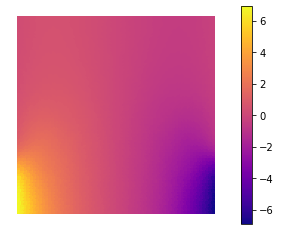

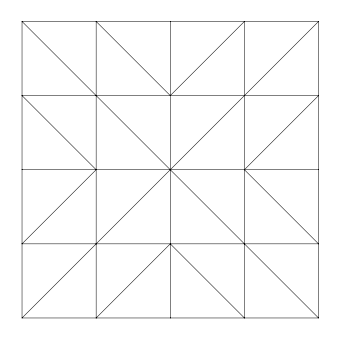

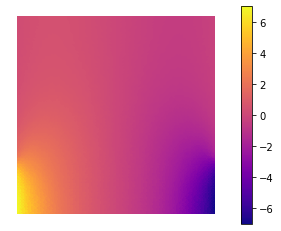

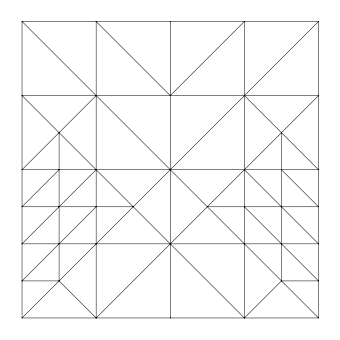

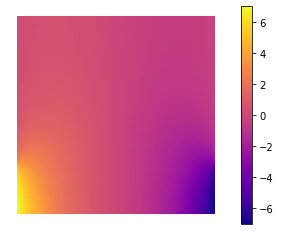

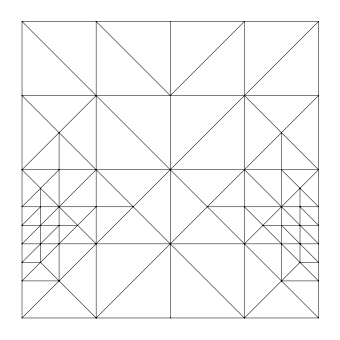

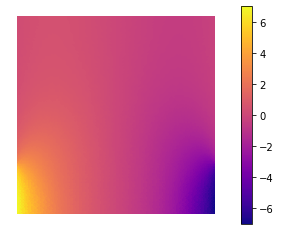

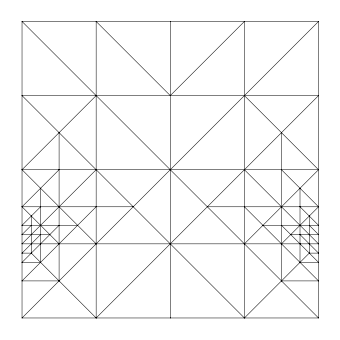

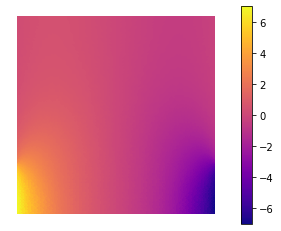

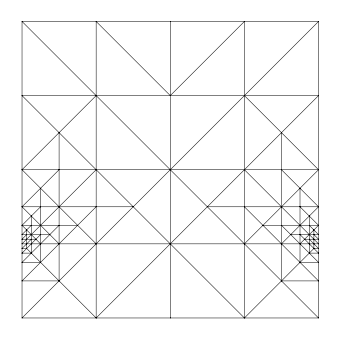

In [13]:
m = MeshTri.init_sqsymmetric()
m.refine(1)
print('N,estimators')
for _ in range(5):
    est = problem(m, eps2=1e0)
    m.refine(adaptive_theta(est))

N,estimators
206,2.0338151615644473
328,1.6210834949132014
450,1.1830971804048744
680,0.8051481495732635
838,0.5066701602907344


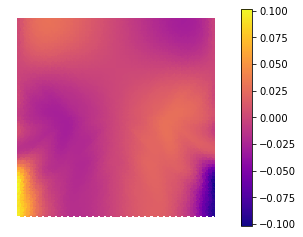

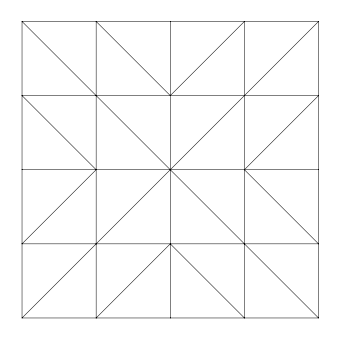

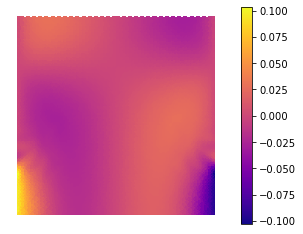

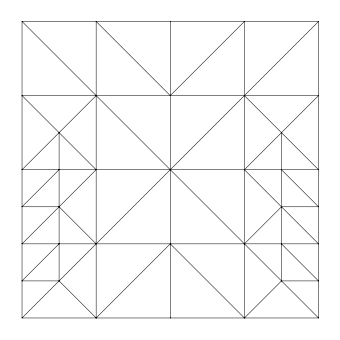

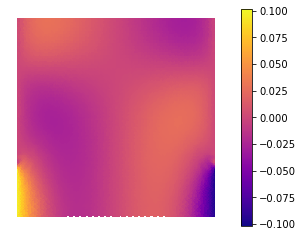

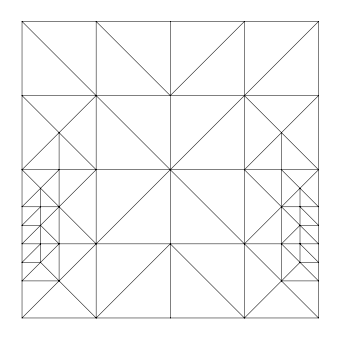

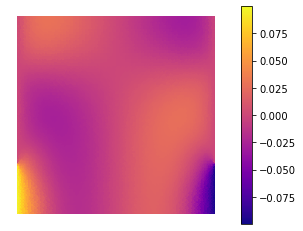

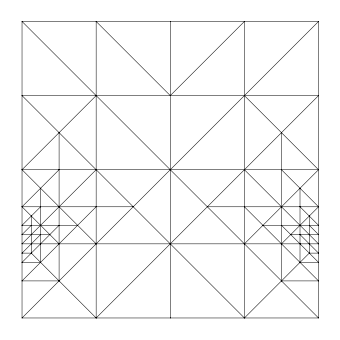

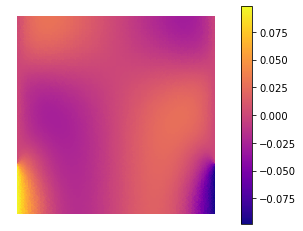

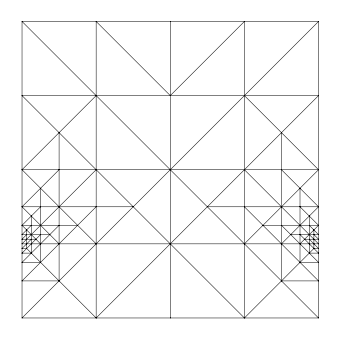

In [14]:
m = MeshTri.init_sqsymmetric()
m.refine(1)
print('N,estimators')
for _ in range(5):
    est = problem(m, eps2=1e-2)
    m.refine(adaptive_theta(est))

N,estimators
206,0.08206518290680914
276,0.04117394603154964
520,0.030238924238375955
642,0.029746634678990424
764,0.029358180583652214


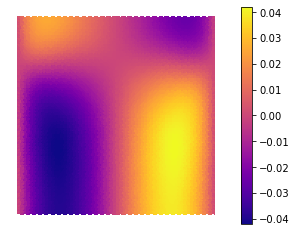

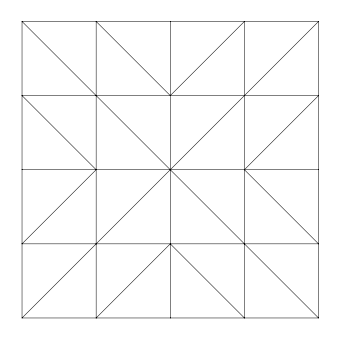

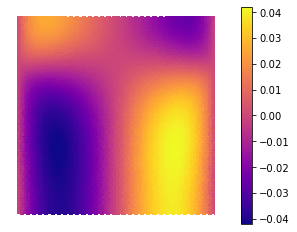

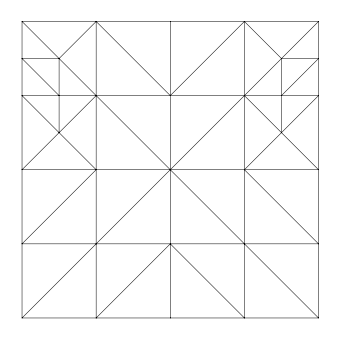

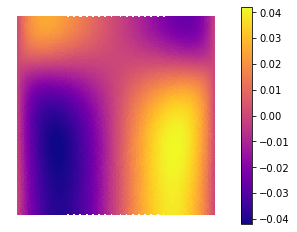

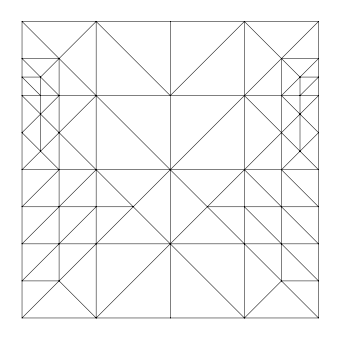

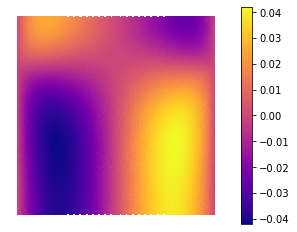

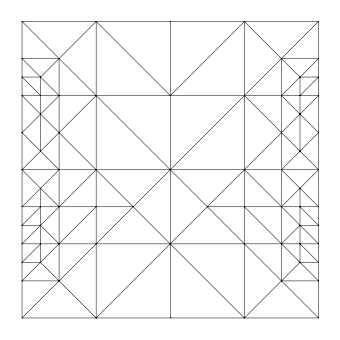

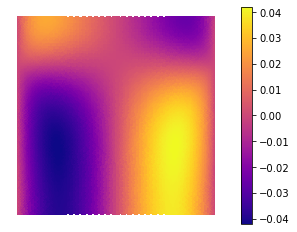

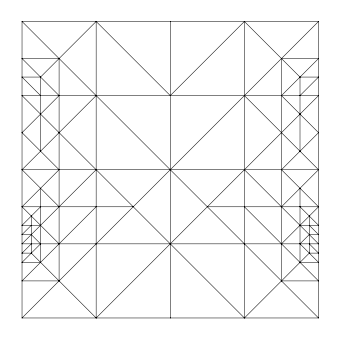

In [15]:
m = MeshTri.init_sqsymmetric()
m.refine(1)
print('N,estimators')
for _ in range(5):
    est = problem(m, eps2=1e-4)
    m.refine(adaptive_theta(est))

N,estimators
206,0.07810526623407765
276,0.029355130087522253
416,0.013596136446411923
635,0.008066595258505716
1010,0.005665658846809847


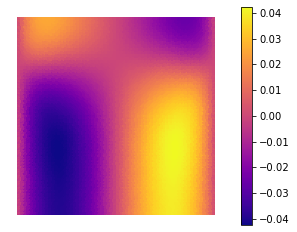

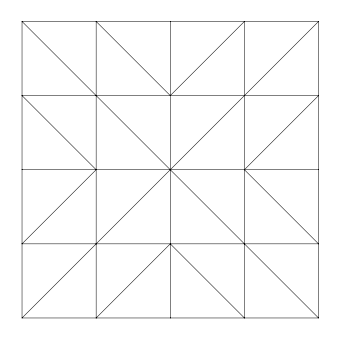

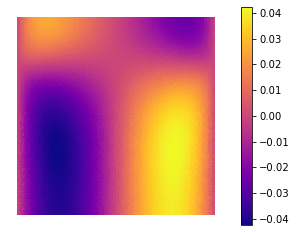

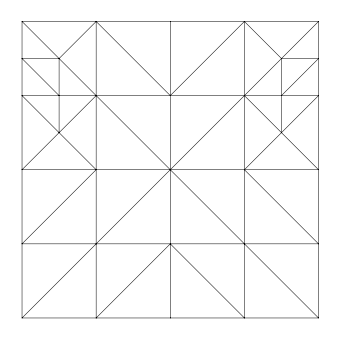

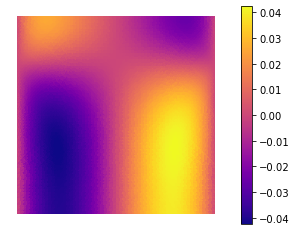

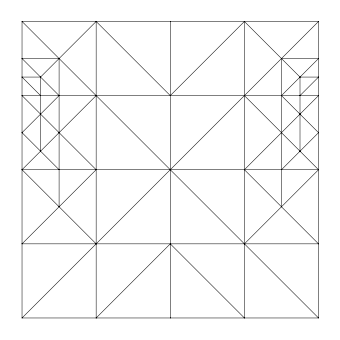

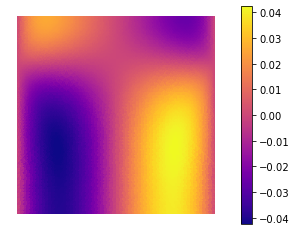

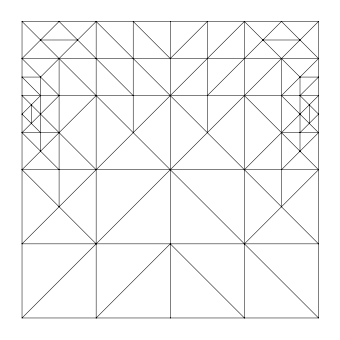

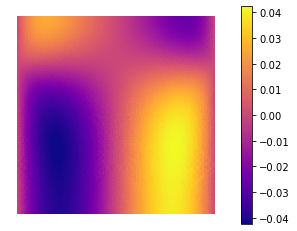

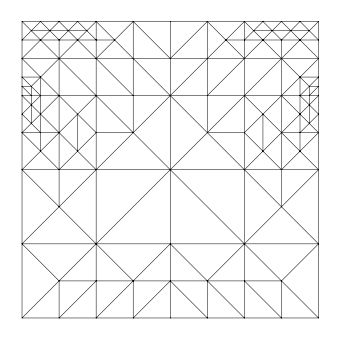

In [16]:
m = MeshTri.init_sqsymmetric()
m.refine(1)
print('N,estimators')
for _ in range(5):
    est = problem(m, eps2=1e-6)
    m.refine(adaptive_theta(est))

# Traditional refinements

N,estimators
206,12.667010258339893
364,6.818697797395999
522,3.5833149698047433
680,1.86160454264117
838,0.9870311679405043


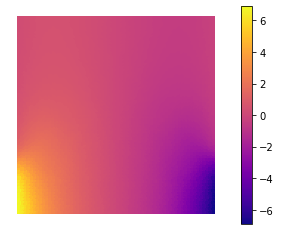

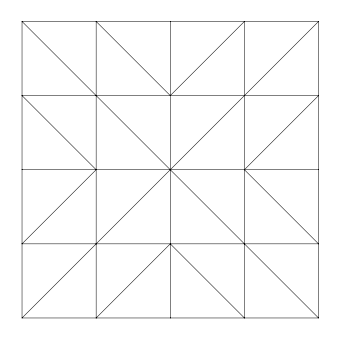

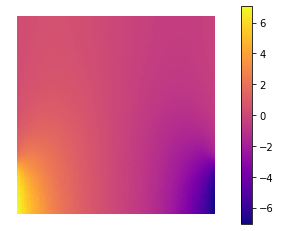

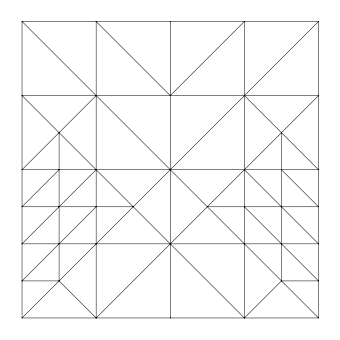

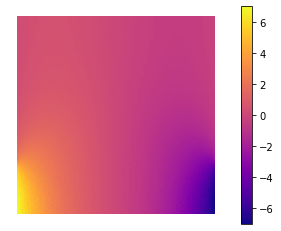

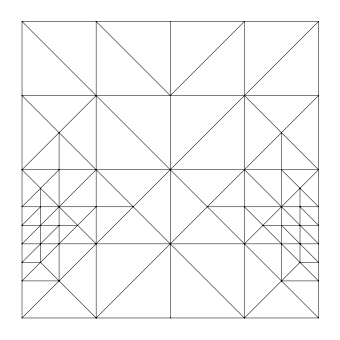

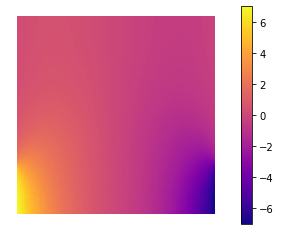

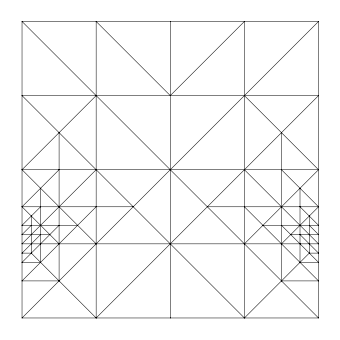

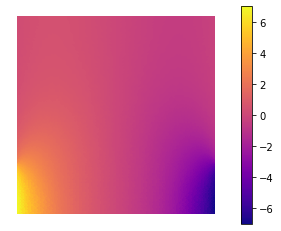

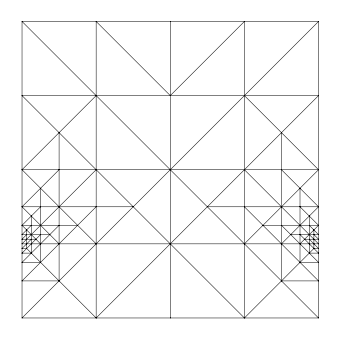

In [7]:
m = MeshTri.init_sqsymmetric()
m.refine(1)
print('N,estimators')
for _ in range(5):
    est = problem(m, eps2=1e0, refmode=1)
    m.refine(adaptive_theta(est))

N,estimators
206,2.1608414033480945
328,1.7039047627795942
450,1.2465627317225592
680,0.8507483796021235
838,0.5357257687496029


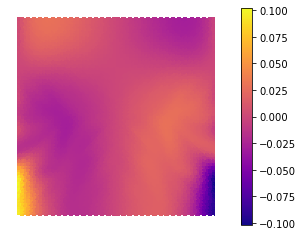

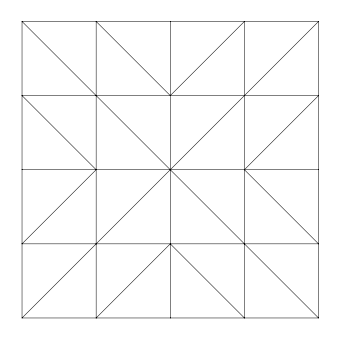

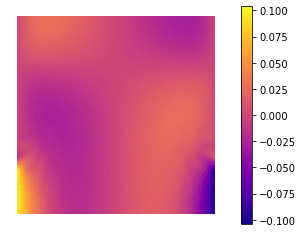

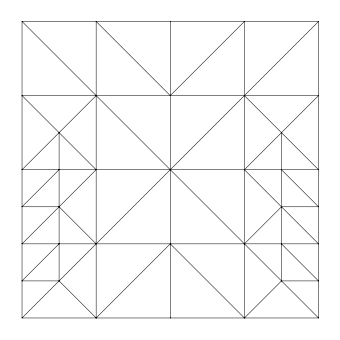

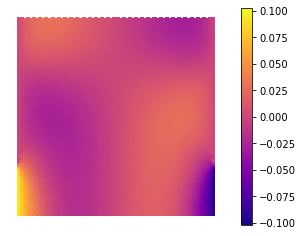

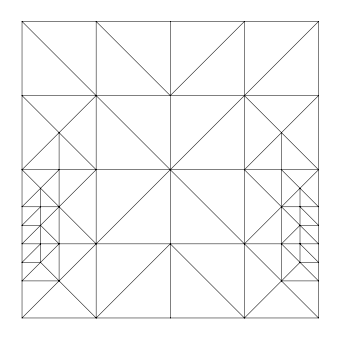

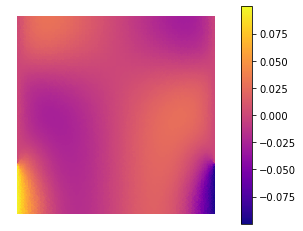

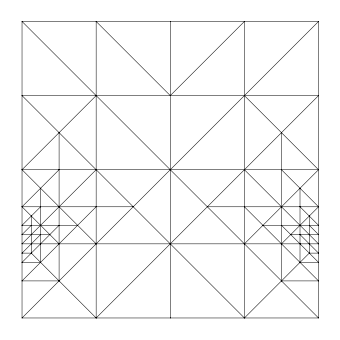

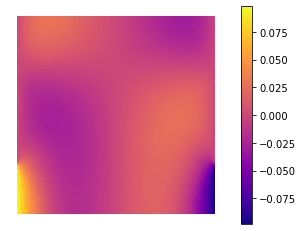

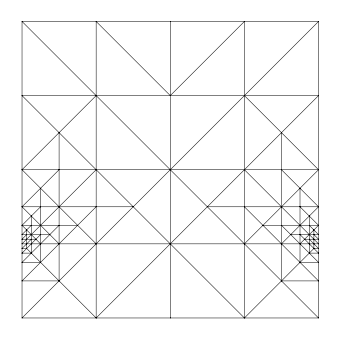

In [8]:
m = MeshTri.init_sqsymmetric()
m.refine(1)
print('N,estimators')
for _ in range(5):
    est = problem(m, eps2=1e-2, refmode=1)
    m.refine(adaptive_theta(est))

N,estimators
206,0.5267759400937897
328,0.2674873088003536
450,0.1424897568663201
572,0.08637420915383703
746,0.04990282822141011


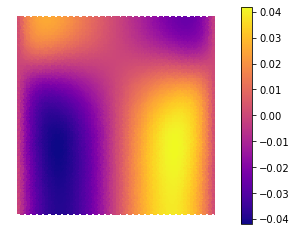

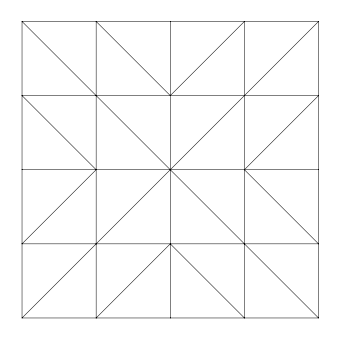

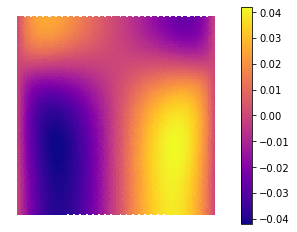

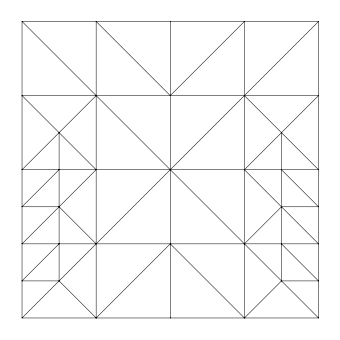

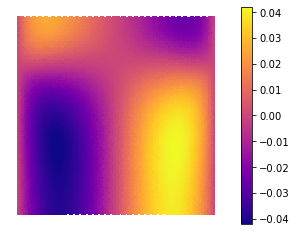

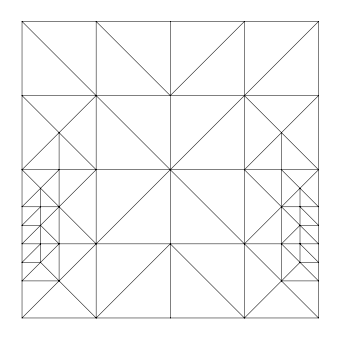

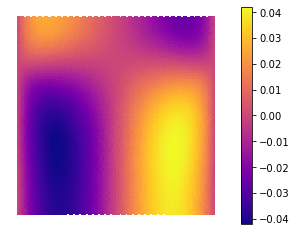

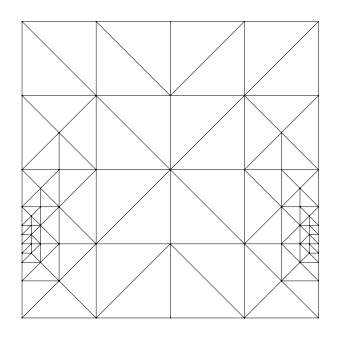

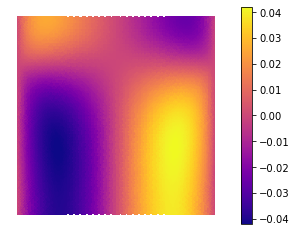

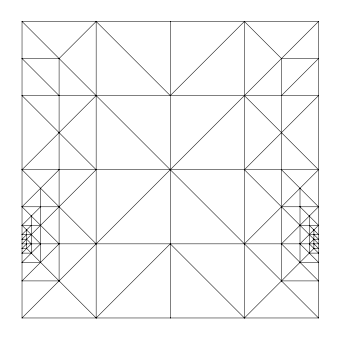

In [9]:
m = MeshTri.init_sqsymmetric()
m.refine(1)
print('N,estimators')
for _ in range(5):
    est = problem(m, eps2=1e-4, refmode=1)
    m.refine(adaptive_theta(est))

N,estimators
206,0.5261430777327235
328,0.2660728529025934
450,0.14017842272980938
572,0.0838554679304626
746,0.1964300745703417


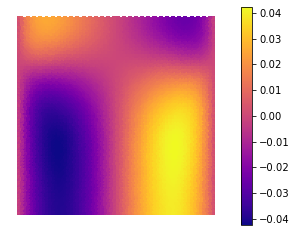

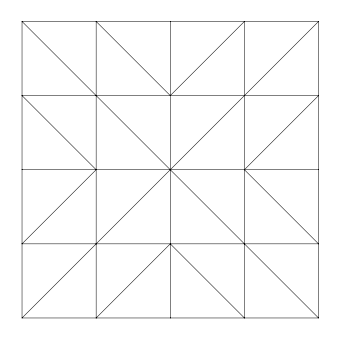

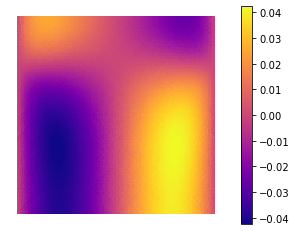

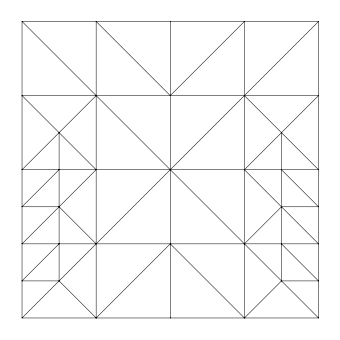

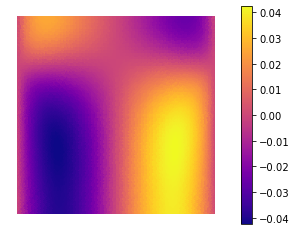

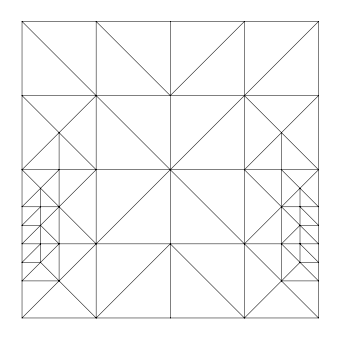

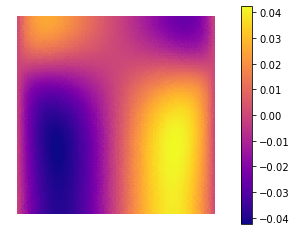

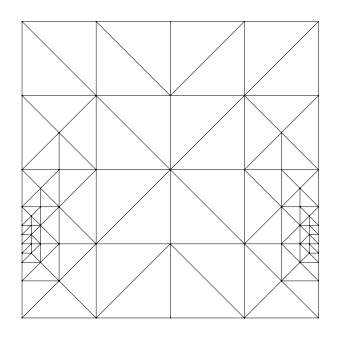

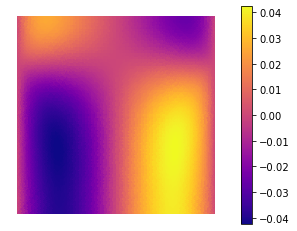

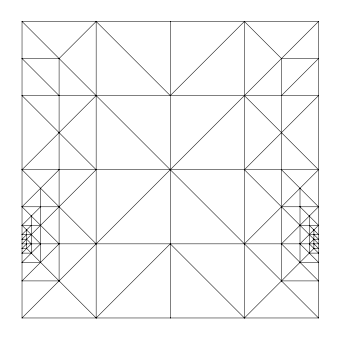

In [10]:
m = MeshTri.init_sqsymmetric()
m.refine(1)
print('N,estimators')
for _ in range(5):
    est = problem(m, eps2=1e-6, refmode=1)
    m.refine(adaptive_theta(est))